In [1]:
%reset -f
### One needs to first run https://www.kaggle.com/left13/various-nets-densenet121-0-96-acc-full-set
### DenseNet121 N_FFT 256 - 23 EPOCHS - 0.96 ACC ON 20% TEST

import os, math
import numpy as np
seed = 2018
np.random.seed(seed)

import librosa
from scipy import signal

from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger

from keras import Model
from keras import backend as K

from keras.utils import np_utils
from keras.preprocessing import image
 
from keras.applications.densenet import DenseNet121

import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
from utils_train import *
from utils import *
from wavhandler import *

Using TensorFlow backend.


In [2]:
current_model = DenseNet121

model_name = 'wingbeats_' + current_model.__name__

best_weights_path = model_name + '.h5'
adapted_best_weights_path = TEMP_DATADIR + 'adapted_' + model_name + '.h5'
scratch_best_weights_path = TEMP_DATADIR + 'scratch_' + model_name + '.h5'
log_path = TEMP_DATADIR + model_name + '.log'
monitor = 'val_acc'
batch_size = 32
epochs = 100
es_patience = 7
rlr_patience = 3

# SR = 8000
# N_FFT = 512
# HOP_LEN = N_FFT / 24
# input_shape = (N_FFT/2+1, 239, 1)
# input_shape = (N_FFT/2+1, 120, 1)
# N_FFT = 256
# HOP_LEN = int(N_FFT / 6)
input_shape = (129, 120, 1)

In [3]:
target_names_wingbeats = mosquitos_6
target_names_adapted = increasing_dataset

In [4]:
from wavhandler import *
from utils import *

DATADIR = '/home/kalfasyan/data/insects/increasing dataset/'
# DATADIR = '/home/kalfasyan/data/insects/LG2/'

target_names = os.listdir(DATADIR)

X, y, filenames = get_data(filedir= DATADIR,
                      target_names=target_names, nr_signals=1000, only_names=False)
print(target_names)

X_names, y = shuffle(filenames, y, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_names, y, stratify = y, test_size = 0.20, random_state = seed)

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


['stigma_female', 'tarsalis_female', 'quinx_male', 'quinx_female', 'fuit_flies', 'house_flies', 'new_aedes_female', 'new_stigma_male', 'aedes_male', 'new_tarsalis_male']


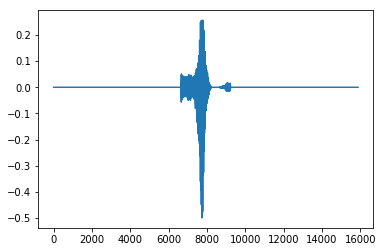

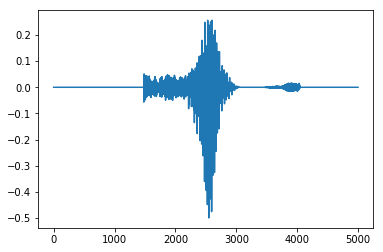

In [18]:
# from utils_train import *
sig = X[0,:]
plt.plot(sig)
plt.figure()
plt.plot(crop_rec(sig))

In [5]:
## train model from scratch
img_input = Input(shape = input_shape)

model = current_model(input_tensor = img_input, classes = len(target_names_adapted), weights = None)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])  

callbacks_list = [ModelCheckpoint(monitor = monitor,
                                filepath = scratch_best_weights_path, 
                                save_best_only = True, 
                                save_weights_only = True,
                                verbose = 1), 
                    EarlyStopping(monitor = monitor,
                                patience = es_patience, 
                                verbose = 1),
                    ReduceLROnPlateau(monitor = monitor,
                                factor = 0.1, 
                                patience = rlr_patience, 
                                verbose = 1),
                    CSVLogger(filename = log_path)]


In [6]:
# model.fit_generator(train_generator(X_train, y_train, batch_size, target_names),
#     steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
#     validation_data = valid_generator(X_test, y_test, batch_size, target_names),
#     validation_steps = int(math.ceil(float(len(X_test)) / float(batch_size))),
#     epochs = epochs,
#     callbacks = callbacks_list,
#     shuffle = False)

In [7]:
model.load_weights(scratch_best_weights_path)

loss, acc = model.evaluate_generator(valid_generator(X_test, y_test, batch_size, target_names, crop=True),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

#print('loss:', loss)
print('Test accuracy:', acc)

print ("")

Test accuracy: 0.7827172825981925



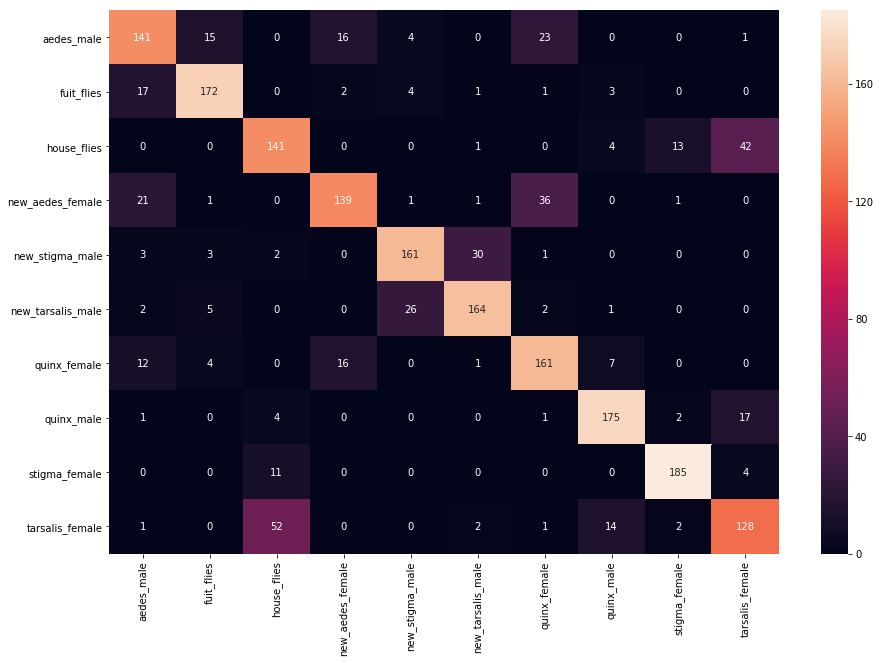

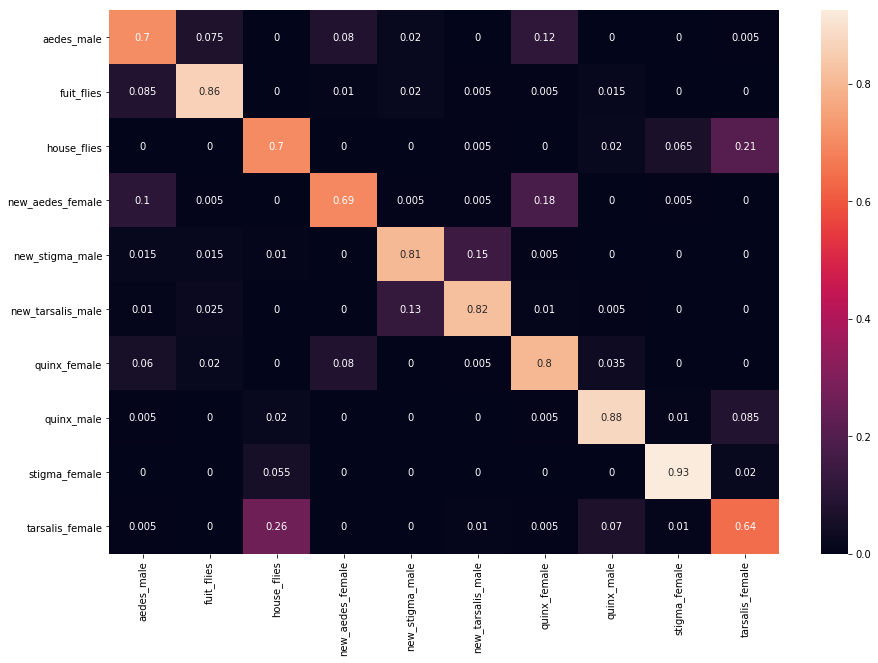

In [8]:
y_pred = np.argmax(model.predict_generator(valid_generator(X_test, y_test, batch_size, target_names, crop=True),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size)))),axis=1)

# Print the confusion matrix
print_confusion(y_test, y_pred, target_names_adapted)